# Import libraries and load data

In [136]:
import matplotlib
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import re
import nltk
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

from matplotlib import pyplot
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
%matplotlib inline
    


%matplotlib inline
url1 = "https://raw.githubusercontent.com/docju/capstone2/main/spamraw.csv"
download1 = requests.get(url1).content


df = pd.read_csv(io.BytesIO(download1))
print(df.head(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
   type                                               text
0   ham  Hope you are having a good week. Just checking in
1   ham                            K..give back my thanks.
2   ham        Am also doing in cbe only. But have to pay.
3  spam  complimentary 4 STAR Ibiza Holiday or £10,000 ...
4  spam  okmail: Dear Dave this is your final notice to...
5   ham  Aiya we discuss later lar... Pick u up at 4 is...
6   ham                             Are you this much buzy
7   ham                    Please ask mummy to call father
8  spam  Marvel Mobile Play the official Ultimate Spide...
9   ham     fyi I'm at usf now, swing by the room whenever


# Explore the data


In [18]:
df.shape

(5559, 2)

In [19]:
df.type.value_counts()

ham     4812
spam     747
Name: type, dtype: int64

In [20]:
# Check for duplicates
df[df.duplicated()].shape

(403, 2)

In [21]:
df=df.drop_duplicates(['type','text'],keep='first')

print(df.shape)

(5156, 2)


In [22]:
df.type.value_counts()

ham     4503
spam     653
Name: type, dtype: int64

# Clean the data

## Remove URL, email, phone, and currency

In [23]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
email_regex='^([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})$'
#obtained from stack overflow
phone_regex='[\+]?[0-9 ]{11,14}'
#'((((\(?0\d{4}\)?\s?\d{3}\s?\d{3})|(\(?0\d{3}\)?\s?\d{3}\s?\d{4})|(\(?0\d{2}\)?\s?\d{4}\s?\d{4}))(\s?\(\d{4}|\d{3}))?)|((\+44\s?7\d{3}|\(?07\d{3}\)?)\s?\d{3}\s?\d{3})|((((\+44\s?\d{4}|\(?0\d{4}\)?)\s?\d{3}\s?\d{3})|((\+44\s?\d{3}|\(?0\d{3}\)?)\s?\d{3}\s?\d{4})|((\+44\s?\d{2}|\(?0\d{2}\)?)\s?\d{4}\s?\d{4}))(\s?\(\d{4}|\d{3}))?$'
currency_regex='[\$|£|€][0-9\,]*\.?\d{2}'#'|[\$|£|€]+/-?\d+(,\d{3})*(\.\d{1,2})?$/'
#'[\$|£|€]\d*\.?\d{2}'
# Write a function that performing basic cleaning on the text data by replacing links, phone numbers, email addresses and currency amounts
def clean_text(text):
    '''
    Cleans the text data by replacing URLs, @-replies, hashtags, and emoji with text placeholders.
    
    INPUT:
    text - (str) text data to be cleaned
    
    OUTPUT:
    text - (str) cleaned text data with placeholders
    '''
    
    # Replace URLs
#    detected_urls = re.findall(url_regex, text)
#    for url in detected_urls:
#        text = text.replace(url, "urlplaceholder")
        
    #Replace phone numbers
    detected_phone = re.findall(phone_regex, text)
    #for i in range(0,len(detected_phone)):
    for phone in detected_phone:
           # if len(phone)>0:
        text = text.replace(phone, " phoneplaceholder ")
    # Replace money amounts
    
    #detected_currency=[]
    detected_currency = re.findall(currency_regex, text)
    for amount in detected_currency:
            text = text.replace(amount," cash_amount ")

    detected_email = re.findall(email_regex, text)
    for amount in detected_email:
        text = text.replace(amount," email_address ")
        
   
    
    return text

# Apply the text cleaning to our text column
df["clean_text"] = df["text"].apply(lambda x: clean_text(x))

    
df[(df['text']!=df['clean_text']) & (df['type']=='ham')].shape

df[(df['text']!=df['clean_text']) & (df['type']=='spam')].shape

(434, 3)

In [33]:
# Drop the original text column and rename it back to text
sms= df.drop("text", axis=1)
sms = sms.rename(columns={"clean_text": "text", "type":"spam"})
sms.shape

(5156, 2)

In [34]:
#change the ham/spam flags to 1 and 0
sms.spam=sms.spam.replace({'ham':0,'spam':1})

sms.head(20)

,spam,text
0,0,Hope you are having a good week. Just checking in
1,0,K..give back my thanks.
2,0,Am also doing in cbe only. But have to pay.
3,1,complimentary 4 STAR Ibiza Holiday or cash_am...
4,1,okmail: Dear Dave this is your final notice to...
5,0,Aiya we discuss later lar... Pick u up at 4 is...
6,0,Are you this much buzy
7,0,Please ask mummy to call father
8,1,Marvel Mobile Play the official Ultimate Spide...
9,0,"fyi I'm at usf now, swing by the room whenever"


In [35]:
sms.spam.value_counts()

0    4503
1     653
Name: spam, dtype: int64

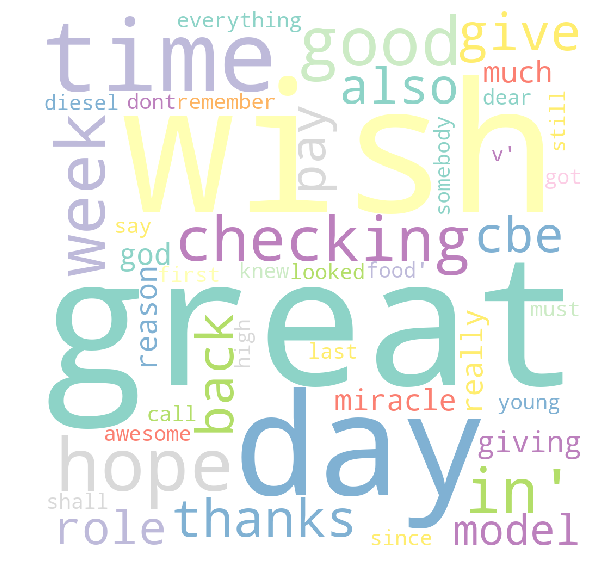

In [161]:
sms['text_norm']=sms['text'].apply(lambda x: re.sub(r"[^a-zA-Z0-9]", " ",x).lower())
ham_words=sms[sms['spam']==0]['text_norm'].values

#ham_words=sms[sms['spam']==0]['text'].values
#Instantiate wordcloud object and use method to feed it our corpus


wc = WordCloud(  width=1000, 
    height=1000, 
    stopwords=stopwords.words("english"),
    min_font_size=8,
    max_words=100,
    background_color='white',
    colormap='Set3').generate_from_text(str(ham_words))


#Turn axis off to get rid of axis numbers
plt.figure(figsize = (10,10))
plt.imshow(wc, interpolation='nearest')
plt.axis('off')
plt.show()

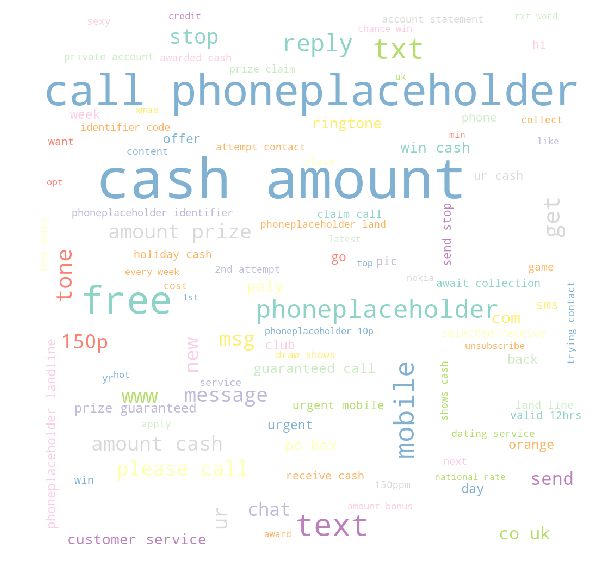

In [162]:
spam_words=sms[sms['spam']==1]['text_norm'].values
#Instantiate wordcloud object and use method to feed it our corpus
wc = WordCloud( width=1000, 
    height=1000, 
    stopwords=stopwords.words("english"),
    min_font_size=8,
    max_words=100,
    background_color='white',
    colormap='Set3').generate_from_text(str(spam_words))

#Use matplotlib.pyplot to display the fitted wordcloud
#Turn axis off to get rid of axis numbers
plt.figure(figsize = (10,10))
plt.imshow(wc, interpolation='nearest')
plt.axis('off')
plt.show()

# Data Pre-Processing

## Normalize and Tokenize the data

In [103]:
# We want to normalize the data to all lower case- 
#however it may be useful for us to know if the original message was all in caps, so we will add a variable to that too

def tokenize(text):
    #lower case
    text=text.lower()
    #keep only text and numericals
    text= re.sub(r"[^a-zA-Z0-9]", " ", text)
    tokens=word_tokenize(text)
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens if word not in stopwords.words("english")]
    return tokens

def upper_flag(text):
    text_upper=re.sub(r"[^a-zA-Z]", "",text.upper())
    upper_case_flag=0
    if text_upper==re.sub(r"[^a-zA-Z]", "",text) and len(text_upper)>0:
        upper_case_flag=1
    return upper_case_flag



In [109]:
for i in range(0,10):
    print(tokenize(sms['text'][i]))

['hope', 'good', 'week', 'checking']
['k', 'give', 'back', 'thanks']
['also', 'cbe', 'pay']
['complimentary', '4', 'star', 'ibiza', 'holiday', 'cash', 'amount', 'cash', 'need', 'urgent', 'collection', 'phoneplaceholder', 'landline', 'lose', 'box434sk38wp150ppm18']
['okmail', 'dear', 'dave', 'final', 'notice', 'collect', '4', 'tenerife', 'holiday', '5000', 'cash', 'award', 'call', 'phoneplaceholder', 'landline', 'tc', 'sae', 'box326', 'cw25wx', '150ppm']
['aiya', 'discus', 'later', 'lar', 'pick', 'u', '4']
['much', 'buzy']
['please', 'ask', 'mummy', 'call', 'father']
['marvel', 'mobile', 'play', 'official', 'ultimate', 'spider', 'man', 'game', 'cash', 'amount', 'ur', 'mobile', 'right', 'text', 'spider', '83338', 'game', 'send', 'u', 'free', '8ball', 'wallpaper']
['fyi', 'usf', 'swing', 'room', 'whenever']


# Feature Engineering

## New text-based features

In [175]:
#denotes if the sms was entirely in upper case
def upper_flag(text):
    text_upper=re.sub(r"[^a-zA-Z]", "",text.upper())
    upper_case_flag=0
    if text_upper==re.sub(r"[^a-zA-Z]", "",text) and len(text_upper)>0:
        upper_case_flag=1
    return upper_case_flag

#count the number of words
def num_of_words(text):
    words=text.split()
    word_count=len(words)
    return word_count

#count the number of alphabet characters

def num_of_alphabet(text):
    text_alpha_only=re.sub(r"[^a-zA-Z]", "",text)
    return len(text_alpha_only)

#number of alphabet characters as a proportion of length of text
def prop_of_alphabet(text):
    text_alpha_only=re.sub(r"[^a-zA-Z]", "",text)
    return len(text_alpha_only)/len(text)

In [176]:
num_of_alphabet(sms.text.iloc[450])

111